# Illustration of policy gradient learning algorithm.

Here, we will build a toy task, and create an agent that solves it using policy-gradient based reinforcement learning.
First, import libraries we will need and enable matplotlib widgets in Jupyter


In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse


## Defining the task environment

First, let's define the task, which we will create in the style of gymnasium environment (a widely used RL library).

The agent class has one key method: "step(action)", which returns the reward obtained when taking a given action.

In [2]:
class Toy2DEnv:
    def __init__(self):
        # define input range and action space (not strictly necessary but in-keeping with gym-style environment class
        self.u1_range = (0.0, 1.0)
        self.u2_range = (0.0, 0.7)
        self.action_space = np.array([self.u1_range, self.u2_range])  # for convenience
        self.observation_space = None  # no state

    # function that determines the reward
    def reward(self, u1, u2):
        # this is an arbitrary function constructed as a Gaussian ridge along a parabolic line
        yy = -1*(u1-0.3)*(u1-1.4) 
        return np.exp(-2*(u1-.7)**2)*np.exp(-20*(u2-yy)**2)
    
    # function to reset the environment (not strictly necessary here, but in-keeping with gym-style environment
    def reset(self):
        """Resets the environment. Returns a dummy observation."""
        return None

    # function to take an action in the environment - outputs obs, done and info are not strictly needed, but in-keeping with gym-style environment
    def step(self, action):
        """Takes an action and returns reward."""
        u1, u2 = action
        r = self.reward(u1, u2)
        obs = None  # stateless
        done = True  # single-step environment
        info = {}
        return obs, r, done, info

    # function for helping with visualization which returns an array of reward values over a uniform grid in action space
    def get_reward_grid(self, resolution=100):
        """Return meshgrid and reward grid for visualization."""
        u1 = np.linspace(*self.u1_range, resolution)
        u2 = np.linspace(*self.u2_range, resolution)
        U1, U2 = np.meshgrid(u1, u2)
        R = self.reward(U1, U2)
        return U1, U2, R

## Defining the learning agent
Next, we define the agent, which will learn the task via policy gradient. We will allow distinct learning rates for different parameters. This is not strictly necessary, but makes it easy to enable or disable different parameter learning.

In [3]:
# agent model - defines the policy and learning rules
# define a simple version of the PGLearner class that neglects the normalization
class PGLearnerSimple:
    def __init__(self, init_mean=None, init_std=None, alpha_mu=0.01, alpha_nu=0.01, alpha_phi=0.01, rwd_baseline_decay=0.99):
        # define learning rates
        self.alpha_mu = alpha_mu
        self.alpha_nu = alpha_nu
        self.alpha_phi = alpha_phi

        # Default mean and standard deviation of the policy
        if init_mean is None:
            init_mean = np.array([0.4, 0.6])
        if init_std is None:
            init_std = np.array([.04, .02]) 
        self.init_mean = np.array(init_mean)
        self.init_std = np.array(init_std)

        # Learnable parameters
        self.mu = init_mean                   # policy mean
        self.nu = np.log([init_std[0]**2, init_std[1]**2])            # log-eigenvalues of policy covariance matrix
        self.phi = 0.0                        # orientation parameter for covariance matrix
        self.Q = self._rotation_matrix(self.phi)

        # reward baseline (recent average reward)
        self.rwd_baseline = 0.0
        self.rwd_baseline_decay = rwd_baseline_decay

    # helper functions for computing the covariance matrix based on parameters nu and phi
    def _rotation_matrix(self, phi):
        return np.array([
            [np.cos(phi), -np.sin(phi)],
            [np.sin(phi),  np.cos(phi)]
        ])

    def _covariance(self):
        Lambda = np.diag(np.exp(self.nu))
        return self.Q @ Lambda @ self.Q.T

    # function to initialize the reward baseline in a given environment based on average reward obtained with current (initial) policy
    def initialize_rwd_baseline(self, env, n_samples=100):
        rewards = []
        for _ in range(n_samples):
            env.reset()
            action = self.select_action()
            _, reward, _, _ = env.step(action)
            rewards.append(reward)
        self.rwd_baseline = np.mean(rewards)

    # function to sample an action from the current poicy
    def select_action(self):
        cov = self._covariance()
        action = np.random.multivariate_normal(self.mu, cov)
        self._last_action = action
        return action  # convert angle to un-normalized action

    # function to update the parameters of the policy via policy gradient based on an action taken and associated reward
    def update(self, action, reward):
        # --- mu update
        cov = self._covariance()
        grad_logp_mu = np.linalg.inv(cov) @ (action - self.mu)
        self.mu += self.alpha_mu * (reward - self.rwd_baseline) * grad_logp_mu

        # --- nu update ---
        z = self.Q.T @ (action - self.mu)
        lambdas = np.exp(self.nu)
        grad_logp_nu = 0.5 * (-1 + (z ** 2) / lambdas)
        self.nu += self.alpha_nu * (reward - self.rwd_baseline) * grad_logp_nu

        # --- phi update ---
        Lambda_inv = np.diag(1.0 / lambdas)
        grad_logp_dQ = - self.Q.T @ np.outer(z, z) @ Lambda_inv
        dQ_dphi = np.array([
            [-np.sin(self.phi), -np.cos(self.phi)],
            [ np.cos(self.phi), -np.sin(self.phi)]
        ])
        grad_logp_phi = np.trace(grad_logp_dQ.T @ dQ_dphi)
        self.phi += self.alpha_phi * (reward - self.rwd_baseline) * grad_logp_phi
        self.Q = self._rotation_matrix(self.phi)

        # --- Update the reward baseline
        self.rwd_baseline = self.rwd_baseline_decay * self.rwd_baseline + (1 - self.rwd_baseline_decay) * reward

    # define some "attributes" to access the mean and covariance of the policy
    @property
    def mean(self):
        return self.mu
    
    # attribute to access the un-normalized covariance matrix
    @property
    def cov(self):
        return self._covariance()


Now that we have defined these, we can create an instance of the environment and an instance of the learning agent. We'll also initialize the reward baseline of the agent based on it's initial policy.

For illustrative purposes, we will use exaggerated learning rates. In practice, smaller learning rates are preferred to improve stability.

In [7]:
env = Toy2DEnv()
learner = PGLearnerSimple(init_mean=[0.5, 0.4], init_std=[0.08, 0.04], alpha_mu=0.005, alpha_nu=0.05, alpha_phi=0.0, rwd_baseline_decay=0.9)
learner.initialize_rwd_baseline(env)
actions = [] # list to store the history of actions

Before starting learning, we'll define a function to help visualize the policy via a covariance ellipse

In [8]:
def plot_covariance_ellipse(mean, cov, ax, n_std=1.0, **kwargs):
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    chisq_val = 5.991  # from chi^2 with 2 degrees of freedom - appropriate for plotting a 95% confidence interval for the covariance ellipse
    width, height = 2 * np.sqrt(chisq_val * eigvals)
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, fill=False, **kwargs)
    ax.add_patch(ellipse)
    return ellipse

Now let's set up a plot where we'll see and guide the evolution of the policy.
Set up and plot a reward heatmap, along with colorbar

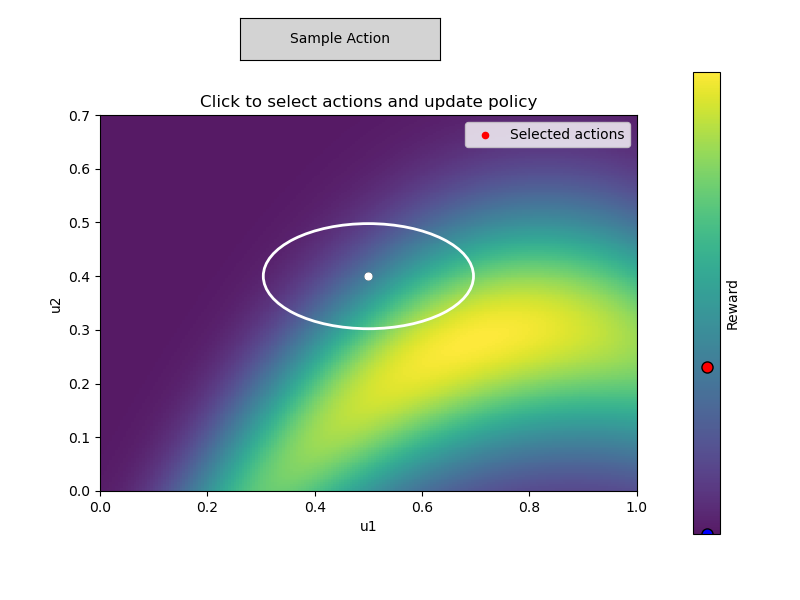

In [9]:
U1, U2, R = env.get_reward_grid(resolution=200)

fig, (ax_main, ax_cbar) = plt.subplots(
    1, 2, figsize=(8, 6), gridspec_kw={"width_ratios": [20, 1]}
)
# Create a new axis for the button (normalized figure coordinates)
from matplotlib.widgets import Button
button_ax = fig.add_axes([0.3, 0.9, 0.25, 0.07])  # [left, bottom, width, height]
sample_button = Button(button_ax, 'Sample Action', color='lightgray', hovercolor='gray')

heatmap = ax_main.pcolormesh(U1, U2, R, shading='auto', cmap='viridis', alpha=0.9)
ax_main.set_xlim(0, 1)
ax_main.set_ylim(0, 0.7)
ax_main.set_xlabel('u1')
ax_main.set_ylabel('u2')
ax_main.set_title('Click to select actions and update policy')
scatter = ax_main.scatter([], [], color='red', s=20, label='Selected actions')

# %%
# Initial ellipse
ellipse = [plot_covariance_ellipse(learner.mean, learner.cov, ax_main, edgecolor='white', lw=2)]

ax_main.legend()
ax_main.set_aspect('equal')

# dot to show last action
last_action_dot = ax_main.plot(
    [learner.mean[0]], [learner.mean[1]], 'b.', markersize=10, markeredgecolor='black'
)

# policy mean
mean_dot = ax_main.plot(
    [learner.mean[0]], [learner.mean[1]], 'w.', markersize=10
)

# --- Reward baseline colorbar ---
norm = plt.Normalize(vmin=R.min(), vmax=R.max())
cbar = plt.colorbar(heatmap, cax=ax_cbar)
cbar.set_label("Reward")

# --- Add reward baseline marker
rwd_dot = ax_cbar.plot(
    [0.5], [learner.rwd_baseline], 'ro', markersize=8, markeredgecolor='black'
)[0]

rwd_latest_dot = ax_cbar.plot(
    [0.5], [0.0], 'bo', markersize=8, markeredgecolor='black'
)[0]

ax_cbar.set_ylim(R.min(), R.max())
ax_cbar.set_xlim(0, 1)
ax_cbar.set_xticks([])
ax_cbar.set_yticks([])

def update_plot(action):
    # Evaluate reward and update learner
    _, reward, _, _ = env.step(action)
    learner.update(action, reward)

    # Update scatter
    scatter.set_offsets(actions)

    # Update ellipse and mean dot
    ellipse[0].remove()
    ellipse[0] = plot_covariance_ellipse(learner.mean, learner.cov, ax_main, edgecolor='white', lw=2)
    mean_dot[0].set_data([learner.mean[0]], [learner.mean[1]])

    # Update last_action
    last_action_dot[0].set_data([action[0]],[action[1]])

    # Update reward dot on color bar
    rwd_dot.set_ydata([learner.rwd_baseline])
    rwd_latest_dot.set_ydata([reward])

    fig.canvas.draw()


def onclick(event):
    if event.inaxes != ax_main:
        return

    action = np.array([event.xdata, event.ydata])
    actions.append(action)

    update_plot(action)

def on_sample(event):
    action = learner.select_action()
    actions.append(action)

    update_plot(action)

sample_button.on_clicked(on_sample)
fig.canvas.mpl_connect('button_press_event', onclick)
plt.show()